# Exploration of Data Set 3

This is the exploratory notebook for data set 3. Data is taken from [nrg.com](https://www.nrg.com/resources/energy-tools/tracking-the-market.html) and is specifically for the electricity data of actual load, day-ahead market and real-time market of New York city. 

# Imports/Custom Functions

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import datetime, timedelta
# Set the default color cycle
mpl.style.use('seaborn-v0_8-notebook')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk')

In [2]:
def get_num_duplicates_and_NaNs(df, keep='first'):
    """
        takes a dataframe,
        prints number of missing values and number of duplicates
        returns the boolean array of duplicates
    """
    print(f'There are {df.isnull().values.sum()} missing values or NaNs in the DataFrame.')
    duplicated_ = df.duplicated(keep=keep)
    print(f'There are {duplicated_.sum()} duplicate rows in DataFrame based on all columns.')
    return duplicated_

def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax
    
def seasons(months):
    """
        months : pandas series containing months (integers)
        returns a pandas series for season
    """
    seasons = []
    for month in months.values:
        season = None
        if month in [1,2,12]:
            season = 0
        elif month in [3,4,5]:
            season = 1
        elif month in [6,7,8]:
            season = 2
        else:
            season = 3
        seasons.append(season)
    return seasons

In [3]:
date_range = pd.date_range(start='2020-09-01', end='2023-12-01')
cal = calendar()
holidays = cal.holidays(start=date_range.min(), end=date_range.max())

# Actual Load

Preliminary work on actual load data. Check for
* duplicates
* NaN's

Next, create new features in the data. Expectation is that knowing the day, hour and minute would be helpful in feature selection later on. Also, it is a good idea to have 3 columns for
  1. whether the day is weekend or not
  2. whether the hour is business hour or not
  3. whether the day is a public holiday or not 

In [4]:
rawAL = pd.read_csv("../data/dat_set_3/market_data_actual_load.csv") ## actual daily load

In [5]:
## these are superfluous 

rawAL.drop(['label','type'],inplace=True, axis=1)
rawAL.rename(columns={'value':'actual_load'}, inplace=True)

In [6]:
rawAL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329074 entries, 0 to 329073
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         329074 non-null  object 
 1   actual_load  322541 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.0+ MB


In [7]:
duplicated_ = get_num_duplicates_and_NaNs(rawAL)

There are 6533 missing values or NaNs in the DataFrame.
There are 34 duplicate rows in DataFrame based on all columns.


In [8]:
## drop the duplicate rows:

rawAL.drop_duplicates(keep='first', subset=['time'], inplace=True)

## interpolate for the NaN's

rawAL.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [9]:
## convert the time column to datetime
## construct new columns for date, hour and minute
rawAL['time']          = pd.to_datetime(rawAL['time'], utc=True, infer_datetime_format=True)
rawAL['date']          = rawAL['time'].dt.date
rawAL['date']          = pd.to_datetime(rawAL['date'])
rawAL['hour']          = rawAL['time'].dt.strftime("%H").astype('int')
rawAL['minute']        = rawAL['time'].dt.strftime("%M").astype('int')
rawAL['weekday']       = rawAL['time'].dt.dayofweek <= 4
rawAL['month']         = rawAL['time'].dt.month
rawAL['month']         = rawAL['month'].astype('int')
rawAL['day_of_week']   = rawAL['time'].dt.dayofweek + 1
#rawAL['holiday']       = rawAL['date'].astype('datetime64[ns]').isin(holidays).astype('int')
rawAL['holiday']       = rawAL['date'].isin(holidays).astype('int')
rawAL['business_hour'] = (rawAL['weekday'].astype(bool)) & (rawAL['hour'].between(8, 17))
for col in ['hour', 'minute', 'weekday', 'business_hour', 'holiday']:
    rawAL[col].astype(np.int64)
rawAL.replace({False: 0, True: 1}, inplace=True)

In [10]:
rawAL['time'] = rawAL['time'].dt.tz_localize(None)

In [11]:
load_data = rawAL.loc[rawAL.minute == 0]
load_data['season'] = seasons(load_data['month'])
load_data.reset_index(drop=True)
del rawAL

In [12]:
## final check: duplicates and NaN's should be gone

duplicated_ = get_num_duplicates_and_NaNs(load_data, False)

There are 0 missing values or NaNs in the DataFrame.
There are 0 duplicate rows in DataFrame based on all columns.


In [13]:
load_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26276 entries, 11 to 329065
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time           26276 non-null  datetime64[ns]
 1   actual_load    26276 non-null  float64       
 2   date           26276 non-null  datetime64[ns]
 3   hour           26276 non-null  int64         
 4   minute         26276 non-null  int64         
 5   weekday        26276 non-null  int64         
 6   month          26276 non-null  int64         
 7   day_of_week    26276 non-null  int32         
 8   holiday        26276 non-null  int64         
 9   business_hour  26276 non-null  int64         
 10  season         26276 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(7)
memory usage: 2.3 MB


# Day-Ahead Prices

I interpret the data of day-ahead to be the real price of that given day (just to clarify the name of the data!!).

In [14]:
rawDA = pd.read_csv("../data/dat_set_3/market_data_day_ahead.csv") ## prices? day-ahead prices

In [15]:
rawDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26328 entries, 0 to 26327
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   26328 non-null  object 
 1   type    26328 non-null  object 
 2   time    26328 non-null  object 
 3   value   26328 non-null  float64
dtypes: float64(1), object(3)
memory usage: 822.9+ KB


In [16]:
rawDA.drop(['label','type'], inplace=True, axis=1)
rawDA.rename(columns={'value':'DA_price'}, inplace=True)

In [17]:
rawDA['time'] = pd.to_datetime(rawDA['time'], utc=True, infer_datetime_format=True)
rawDA['time'] = rawDA['time'].dt.tz_localize(None)

In [18]:
rawDA.head(3)

,time,DA_price
0,2020-10-27 00:00:00,18.44
1,2020-10-27 01:00:00,17.83
2,2020-10-27 02:00:00,16.44


In [19]:
duplicates_ = get_num_duplicates_and_NaNs(rawDA)

There are 0 missing values or NaNs in the DataFrame.
There are 0 duplicate rows in DataFrame based on all columns.


In [20]:
df_final = rawDA.merge(load_data, on=['time'], how='inner')

In [21]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26273 entries, 0 to 26272
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time           26273 non-null  datetime64[ns]
 1   DA_price       26273 non-null  float64       
 2   actual_load    26273 non-null  float64       
 3   date           26273 non-null  datetime64[ns]
 4   hour           26273 non-null  int64         
 5   minute         26273 non-null  int64         
 6   weekday        26273 non-null  int64         
 7   month          26273 non-null  int64         
 8   day_of_week    26273 non-null  int32         
 9   holiday        26273 non-null  int64         
 10  business_hour  26273 non-null  int64         
 11  season         26273 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(7)
memory usage: 2.3 MB


In [22]:
df_final.head(3)

,time,DA_price,actual_load,date,hour,minute,weekday,month,day_of_week,holiday,business_hour,season
0,2020-10-27 01:00:00,17.83,4137.0,2020-10-27,1,0,1,10,2,0,0,3
1,2020-10-27 02:00:00,16.44,3984.0,2020-10-27,2,0,1,10,2,0,0,3
2,2020-10-27 03:00:00,15.45,3895.0,2020-10-27,3,0,1,10,2,0,0,3


In [23]:
df_final.drop_duplicates(keep='first', subset=['time'], inplace=True)

# Incorporate Weather Data

In [24]:
rawWeather = pd.read_csv("../data/dat_set_3/NYC_weather_data.csv", parse_dates=['dtime']) ## weather data
rawWeather.drop(['index','week','month'], inplace=True, axis=1)

In [25]:
rawWeather['time'] = rawWeather['dtime'].dt.tz_convert('UTC')
rawWeather['time'] = rawWeather['time'].dt.tz_localize(None)

In [26]:
rawWeather.drop(['dtime'], inplace=True, axis=1)

In [27]:
rawWeather.head(3)

,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,weekly_T_anom,monthly_T_anom,...,monthly_Prec_anom,weekly_Wind_anom,monthly_Wind_anom,weekly_Pressure_anom,monthly_Pressure_anom,snowing,raining,hail,cloudy,time
0,10.4,8.6,89.2,0.2,50.0,15.6,1023.6,5.5,-0.269624,-0.997096,...,-0.04199,1.081601,0.622146,0.324112,1.111573,0,0,0,1,2020-10-26 05:00:00
1,10.6,8.9,89.5,0.2,40.0,13.7,1023.5,6.3,-0.229108,-0.952695,...,-0.04199,0.732361,0.315140,0.305731,1.095415,0,1,0,1,2020-10-26 06:00:00
2,10.6,9.3,91.7,0.2,24.0,15.2,1023.3,6.3,-0.229108,-0.952695,...,-0.04199,1.008077,0.557513,0.268969,1.063098,0,1,0,1,2020-10-26 07:00:00


In [28]:
df_final = df_final.merge(rawWeather, on=['time'], how='inner', suffixes=('', ''))

In [29]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25640 entries, 0 to 25639
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time                   25640 non-null  datetime64[ns]
 1   DA_price               25640 non-null  float64       
 2   actual_load            25640 non-null  float64       
 3   date                   25640 non-null  datetime64[ns]
 4   hour                   25640 non-null  int64         
 5   minute                 25640 non-null  int64         
 6   weekday                25640 non-null  int64         
 7   month                  25640 non-null  int64         
 8   day_of_week            25640 non-null  int32         
 9   holiday                25640 non-null  int64         
 10  business_hour          25640 non-null  int64         
 11  season                 25640 non-null  int64         
 12  temp                   25640 non-null  float64       
 13  d

In [30]:
df_final.head(3)

,time,DA_price,actual_load,date,hour,minute,weekday,month,day_of_week,holiday,...,weekly_Prec_anom,monthly_Prec_anom,weekly_Wind_anom,monthly_Wind_anom,weekly_Pressure_anom,monthly_Pressure_anom,snowing,raining,hail,cloudy
0,2020-10-27 01:00:00,17.83,4137.0,2020-10-27,1,0,1,10,2,0,...,-0.056634,-0.172848,-0.977077,-1.187575,-0.447892,0.432928,0,0,0,1
1,2020-10-27 02:00:00,16.44,3984.0,2020-10-27,2,0,1,10,2,0,...,-0.056634,-0.172848,-1.271174,-1.446107,-0.447892,0.432928,0,0,0,1
2,2020-10-27 03:00:00,15.45,3895.0,2020-10-27,3,0,1,10,2,0,...,-0.056634,-0.172848,-1.602033,-1.736955,-0.466273,0.416769,0,0,0,1


In [31]:
df_final.tail(3)

,time,DA_price,actual_load,date,hour,minute,weekday,month,day_of_week,holiday,...,weekly_Prec_anom,monthly_Prec_anom,weekly_Wind_anom,monthly_Wind_anom,weekly_Pressure_anom,monthly_Pressure_anom,snowing,raining,hail,cloudy
25637,2023-10-01 03:00:00,20.76,3974.0,2023-10-01,3,0,0,10,7,0,...,-0.307488,-0.221899,-1.002141,-0.487515,0.530091,0.957355,0,0,0,0
25638,2023-10-01 04:00:00,19.29,3875.0,2023-10-01,4,0,0,10,7,0,...,-0.307488,-0.221899,-0.821252,-0.317756,0.550189,0.976217,0,0,0,0
25639,2023-10-01 05:00:00,19.75,3864.0,2023-10-01,5,0,0,10,7,0,...,-0.307488,-0.303706,-1.645303,-0.896727,0.550189,0.820725,0,0,0,0


In [32]:
for col in df_final:
    if col not in ['date', 'dtime', 'time']:
        df_final[col] = df_final[col].astype(np.float64)

In [33]:
df_final.columns

Index(['time', 'DA_price', 'actual_load', 'date', 'hour', 'minute', 'weekday',
       'month', 'day_of_week', 'holiday', 'business_hour', 'season', 'temp',
       'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'weekly_T_anom',
       'monthly_T_anom', 'weekly_Prec_anom', 'monthly_Prec_anom',
       'weekly_Wind_anom', 'monthly_Wind_anom', 'weekly_Pressure_anom',
       'monthly_Pressure_anom', 'snowing', 'raining', 'hail', 'cloudy'],
      dtype='object')

# Incorporate Real-time data

In [34]:
rawRT = pd.read_csv("../data/dat_set_3/market_data_real_time.csv") ## real-time market data

In [35]:
rawRT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324144 entries, 0 to 324143
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   324144 non-null  object 
 1   type    324144 non-null  object 
 2   time    324144 non-null  object 
 3   value   324144 non-null  float64
dtypes: float64(1), object(3)
memory usage: 9.9+ MB


In [36]:
## these are superfluous 

rawRT.drop(['label','type'],inplace=True, axis=1)
rawRT.rename(columns={'value':'RT_price'}, inplace=True)

In [37]:
duplicates_ = get_num_duplicates_and_NaNs(rawDA)

There are 0 missing values or NaNs in the DataFrame.
There are 0 duplicate rows in DataFrame based on all columns.


In [38]:
rawRT['time'] = pd.to_datetime(rawRT['time'], utc=True, infer_datetime_format=True)
rawRT['time'] = rawRT['time'].dt.tz_localize(None)

In [39]:
df_final = df_final.merge(rawRT, on=['time'], how='inner', suffixes=('', ''))

In [40]:
df_final.drop_duplicates(keep='first', subset=['time'], inplace=True)

# Preliminary Analysis

Best thing to do is to begin by plotting! We have 3 years worth of data and some of it is going be used as the test set. I don't think I'm going to be terribly biased by plotting the whole data set during this preliminary analysis or using all the data for correlation/stationarity studies but just to be safe, let's remove the last 6 months. I think this would be reasonable as it is a large time window and we can then use test dates within the last 6 months for overall scoring of our models.

In [41]:
edf = df_final[ (df_final.date >= datetime(2020,10,27)) & (df_final.date < datetime(2023,4,1))]

In [42]:
edf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21243 entries, 0 to 21242
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time                   21243 non-null  datetime64[ns]
 1   DA_price               21243 non-null  float64       
 2   actual_load            21243 non-null  float64       
 3   date                   21243 non-null  datetime64[ns]
 4   hour                   21243 non-null  float64       
 5   minute                 21243 non-null  float64       
 6   weekday                21243 non-null  float64       
 7   month                  21243 non-null  float64       
 8   day_of_week            21243 non-null  float64       
 9   holiday                21243 non-null  float64       
 10  business_hour          21243 non-null  float64       
 11  season                 21243 non-null  float64       
 12  temp                   21243 non-null  float64       
 13  dwpt  

## Correlations

A way to determine what to include as input to our model is to look at correlations. There are three correlation measures provided by Pandas (though the underlying function is one from `numpy`)
1. Pearson correlation coefficient: $\rho(X,Y) = \frac{E[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y}$
2. Kendall Rank correlation coefficient: $\tau = \frac{2}{n(n-1)}\sum_\limits{i<j}\mathrm{sgn}(x_i-x_j)\;\mathrm{sgn}(y_i-y_j)$
3. Spearman's rank correlation coefficient: $r_s = \frac{\mathrm{cov}(R(X),R(Y))}{\sigma_{R(X)}\;\sigma_{R(Y)}}$ where $R(X)$ is the rank of the $X$ variable. 

In [43]:
correlation_minimum_cutoff = 0.1

In [44]:
correlations_pearson = edf.corrwith(edf['DA_price'], method='pearson', numeric_only=True, axis=0)
pearson_large_corr = correlations_pearson[abs(correlations_pearson)>correlation_minimum_cutoff]
print(abs(pearson_large_corr).sort_values(ascending=False).to_string())

DA_price         1.000000
actual_load      0.536937
RT_price         0.440791
hour             0.147824
business_hour    0.136867


In [45]:
correlations_kendall = edf.corrwith(edf['DA_price'], method='kendall', numeric_only=True, axis=0)
kendall_large_corr = correlations_kendall[abs(correlations_kendall)>correlation_minimum_cutoff]
print(abs(kendall_large_corr).sort_values(ascending=False).to_string())

DA_price         1.000000
RT_price         0.579388
actual_load      0.416777
dwpt             0.143408
business_hour    0.137416
temp             0.128466
hour             0.123430


In [46]:
correlations_spearman = edf.corrwith(edf['DA_price'], method='spearman', numeric_only=True, axis=0)
spearman_large_corr = correlations_spearman[abs(correlations_spearman)>correlation_minimum_cutoff]
print(abs(spearman_large_corr).sort_values(ascending=False).to_string())

DA_price         1.000000
RT_price         0.753233
actual_load      0.592139
dwpt             0.211488
temp             0.187643
hour             0.180597
business_hour    0.168285
season           0.113884
month            0.108585
day_of_week      0.103734
weekday          0.103047


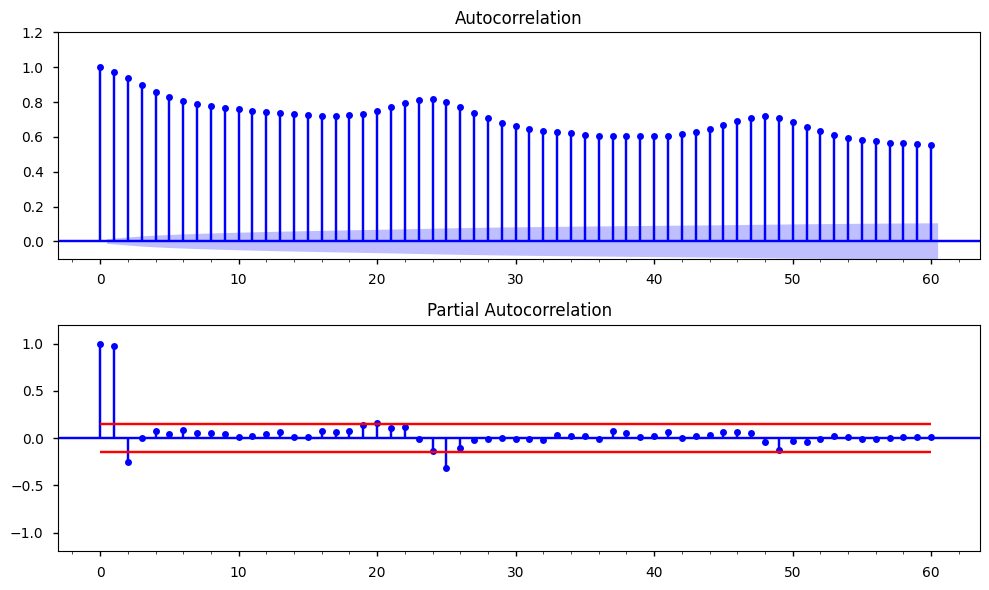

In [47]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(edf['DA_price'] , lags=60, ax=ax1)
plot_pacf(edf['DA_price'], lags=60, ax=ax2)
plt.tight_layout()
for ax in (ax1, ax2):
    ax.xaxis.set_minor_locator(MultipleLocator(2))
ax1.set_ylim(bottom=-0.1, top=1.2)
ax2.set_ylim(bottom=-1.2, top=1.2)
ax2.hlines(0.15, 0, 60, color='red')
ax2.hlines(-0.15, 0, 60, color='red')

In [48]:
## autocorrelation: what part of the time series is more correlated/anti-correlated to present time?
xydata = ax1.get_lines()[1].get_xydata()
for xx, yy in xydata:
    if abs(yy) > 0.90:
        print(f"{int(xx)}, {yy:0.3f}")

0, 1.000
1, 0.974
2, 0.936


In [49]:
## partial autocorrelation: what part of the time series is more correlated/anti-correlated to present time?
xydata = ax2.get_lines()[1].get_xydata()
for xx, yy in xydata:
    if abs(yy) > 0.05:
        print(f"{int(xx)}, {yy:0.3f}")

0, 1.000
1, 0.974
2, -0.255
4, 0.074
6, 0.090
7, 0.054
8, 0.051
13, 0.067
16, 0.071
17, 0.068
18, 0.072
19, 0.138
20, 0.160
21, 0.102
22, 0.123
24, -0.138
25, -0.312
26, -0.104
37, 0.075
38, 0.059
41, 0.064
45, 0.065
46, 0.064
47, 0.059
49, -0.123


There's decent correlation for $t-\left[1,2\right]$,$t-\left[19\cdots 26\right]$ and $t-49$. I can construct and add all of these as features. However, care must be taken about what is actually used in the training and forecasting. 

Do the same thing for the load:

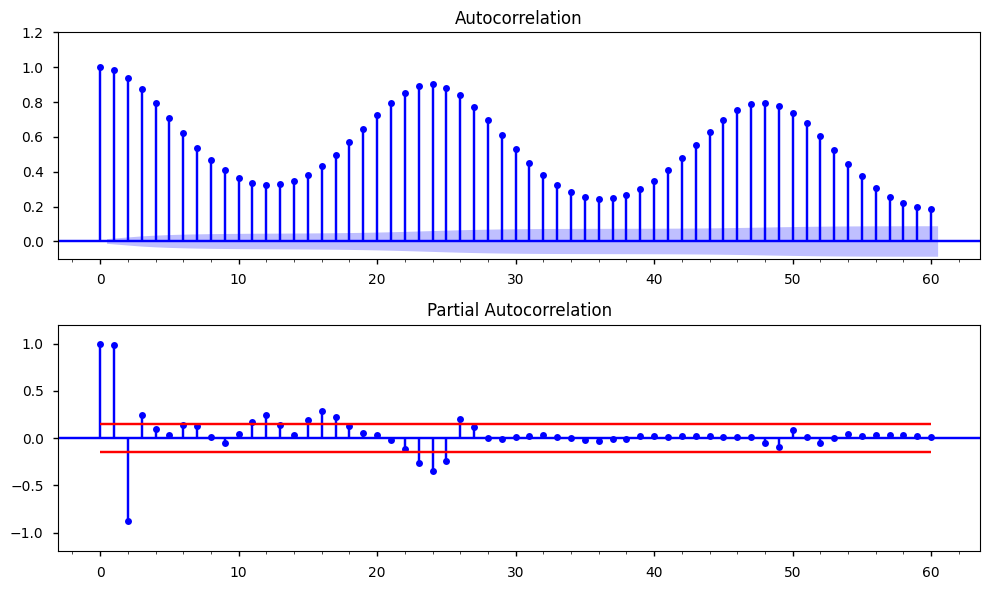

In [50]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(edf['actual_load'] , lags=60, ax=ax1)
plot_pacf(edf['actual_load'], lags=60, ax=ax2)
plt.tight_layout()
for ax in (ax1, ax2):
    ax.xaxis.set_minor_locator(MultipleLocator(2))
ax1.set_ylim(bottom=-0.1, top=1.2)
ax2.set_ylim(bottom=-1.2, top=1.2)
ax2.hlines(0.15, 0, 60, color='red')
ax2.hlines(-0.15, 0, 60, color='red')

In [51]:
## autocorrelation: what part of the time series is more correlated/anti-correlated to present time?
xydata = ax1.get_lines()[1].get_xydata()
for xx, yy in xydata:
    if abs(yy) > 0.90:
        print(f"{int(xx)}, {yy:0.3f}")

0, 1.000
1, 0.984
2, 0.939
24, 0.901


In [52]:
## partial autocorrelation: what part of the time series is more correlated/anti-correlated to present time?
xydata = ax2.get_lines()[1].get_xydata()
for xx, yy in xydata:
    if abs(yy) > 0.05:
        print(f"{int(xx)}, {yy:0.3f}")

0, 1.000
1, 0.984
2, -0.875
3, 0.246
4, 0.097
6, 0.136
7, 0.130
9, -0.052
11, 0.169
12, 0.248
13, 0.140
15, 0.188
16, 0.287
17, 0.220
18, 0.133
19, 0.056
22, -0.113
23, -0.259
24, -0.347
25, -0.247
26, 0.207
27, 0.117
49, -0.091
50, 0.091
52, -0.051


# Plotting

In [53]:
rolling_daily = edf['DA_price'].rolling(24, center=True, min_periods=24).mean()
rolling_weekly = edf['DA_price'].rolling(24*7, center=True, min_periods=24).mean()
rolling_monthly = edf['DA_price'].rolling(24*7*4, center=True, min_periods=24).mean()

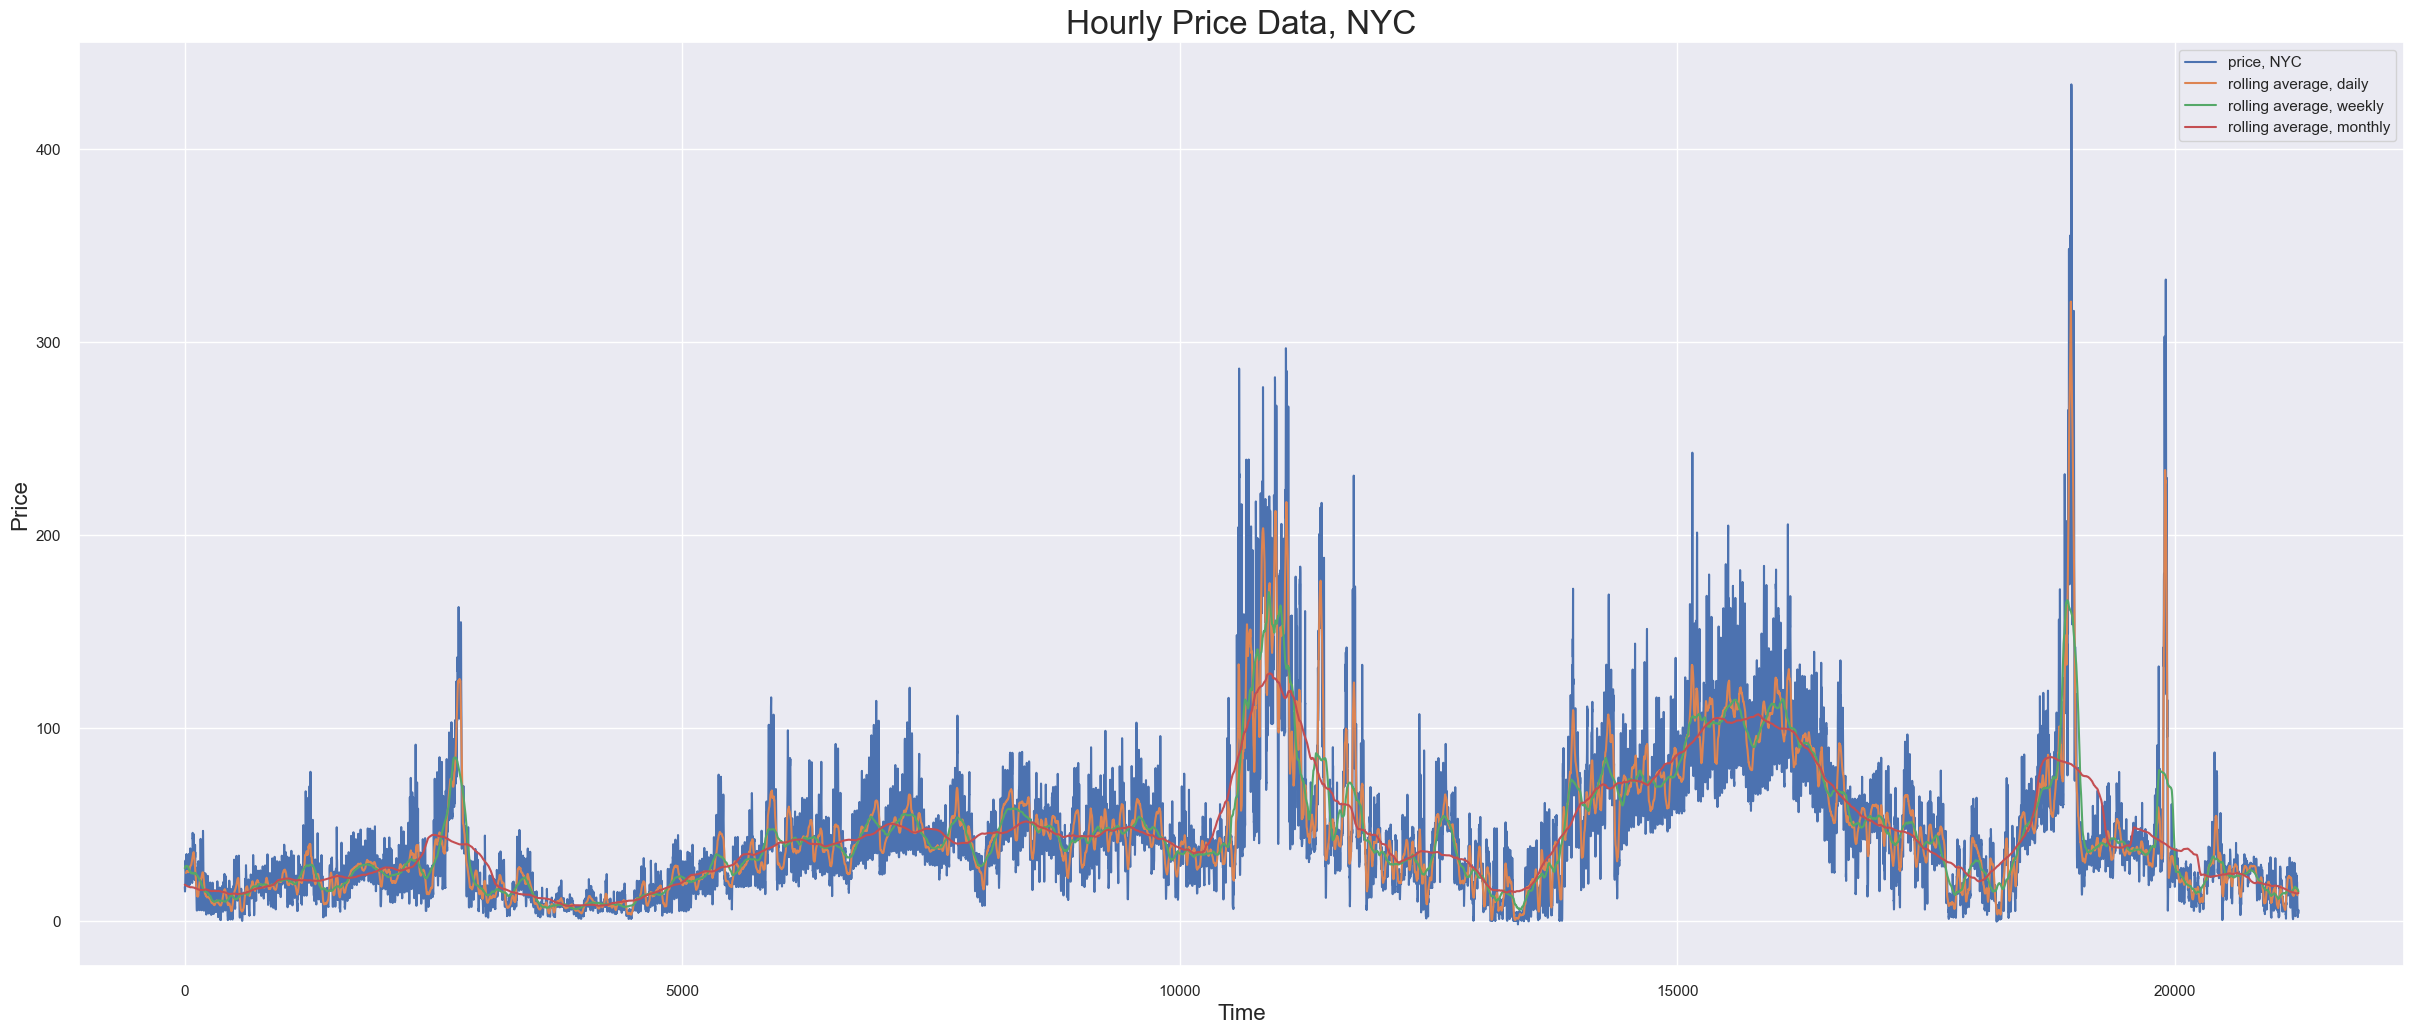

In [54]:
ax = plot_series(df=edf, column='DA_price', label='price, NYC', 
                 ylabel='Price', title="Hourly Price Data, NYC", start=0, end=-1)
ax.plot(rolling_daily, label='rolling average, daily')
ax.plot(rolling_weekly, label='rolling average, weekly')
ax.plot(rolling_monthly, label='rolling average, monthly')
ax.legend(loc='best')

In [55]:
load_rolling_daily = edf['actual_load'].rolling(24, center=True, min_periods=24).mean()
load_rolling_weekly = edf['actual_load'].rolling(24*7, center=True, min_periods=24).mean()
load_rolling_monthly = edf['actual_load'].rolling(24*7*4, center=True, min_periods=24).mean()

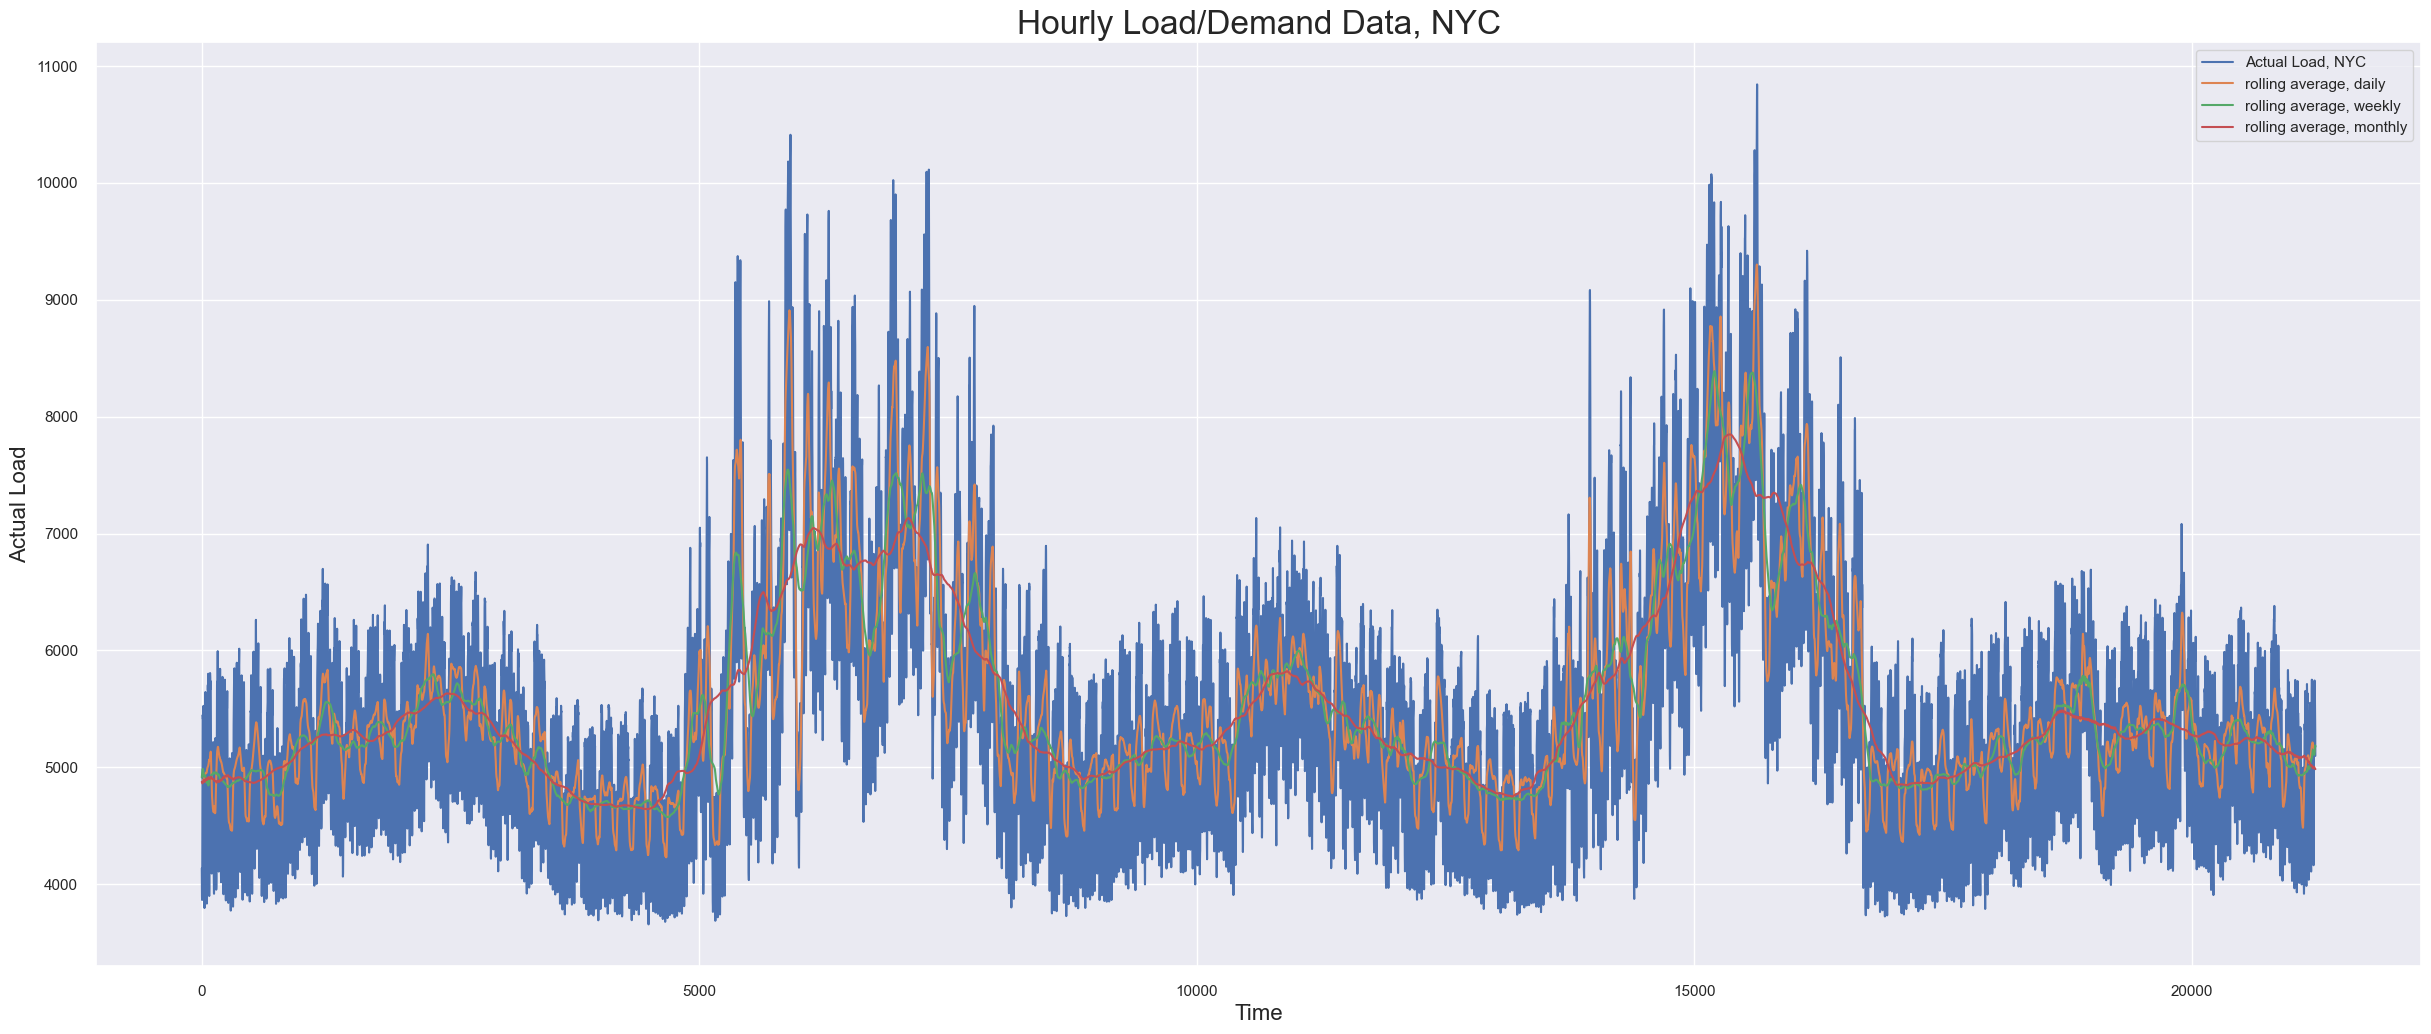

In [56]:
ax = plot_series(df=edf, column='actual_load', label='Actual Load, NYC', 
                 ylabel='Actual Load', title="Hourly Load/Demand Data, NYC", start=0, end=-1)
ax.plot(load_rolling_daily, label='rolling average, daily')
ax.plot(load_rolling_weekly, label='rolling average, weekly')
ax.plot(load_rolling_monthly, label='rolling average, monthly')
ax.legend(loc='best')

## Stationarity

In [57]:
y = edf['DA_price']

In [58]:
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -5.734700
p-value: 0.000001
#Lags used: 46
Critical Value (1%): -3.430659
Critical Value (5%): -2.861676
Critical Value (10%): -2.566843


In [59]:
kpss_test = kpss(y, regression='c', nlags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 6.789875
p-value: 0.010000
#Lags used: 46
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


/var/folders/qj/6_45_pmj2dg62clgp2ksdf6c0000gn/T/ipykernel_41583/752821880.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(y, regression='c', nlags='legacy')


Both of the tests above show stationarity in the price data. Now, I'm also curious about the stationarity of the load data. This is not necessary for the current project (since we're not going to do load forecasting).

In [60]:
y = edf['actual_load']

In [61]:
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -7.350431
p-value: 0.000000
#Lags used: 46
Critical Value (1%): -3.430659
Critical Value (5%): -2.861676
Critical Value (10%): -2.566843


In [62]:
kpss_test = kpss(y, regression='c', nlags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 1.463107
p-value: 0.010000
#Lags used: 46
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


/var/folders/qj/6_45_pmj2dg62clgp2ksdf6c0000gn/T/ipykernel_41583/752821880.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(y, regression='c', nlags='legacy')


# Feature Selection/Creation

Base on the above, there are a few new features I should create and add to the dataframe. These are:
1. price data for $t-\left[1,2\right]$,$t-\left[19\cdots 26\right]$ and $t-49$ hours (i.e. price an hour, 2 hours, 20 hours and 25 hours ago)
2. Souparna (via this [paper](https://www.sciencedirect.com/science/article/abs/pii/S0306261916304160)) also has _price in the same hour in the previous day and previous week_, as well as _load for the previous day and previous week_ (both at the same hour). There are also _average load_ and _average price_ in the previous day.
The features selected based on the correlations calculated above are _`actual_load`, `hour`, `business_hour`, `weekday`, `temp`, `dwpt`_.
Based on the above, I have to drop the first week of the data set, since I won't have enough data to fill out the features in the second point above. 

In [63]:
df_final.drop(['rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'weekly_T_anom',
       'monthly_T_anom', 'weekly_Prec_anom', 'monthly_Prec_anom',
       'weekly_Wind_anom', 'monthly_Wind_anom', 'weekly_Pressure_anom',
       'monthly_Pressure_anom', 'snowing', 'raining', 'hail', 'cloudy'], inplace=True, axis=1)

In [64]:
## add in the price data based on bullet point 1 in the above:
chosen_time_deltas_price = [1, 2, 19, 20, 21, 22, 23, 24, 25, 26, 49]
for index, row in df_final.iterrows():
    if index - max(chosen_time_deltas_price) < 0:
        for j in chosen_time_deltas_price: 
            df_final.at[index,f'price(h-{j})']  = -1
            df_final.at[index,f'load(h-{j})']  = -1
    else: 
        for j in chosen_time_deltas_price: 
            df_final.at[index,f'price(h-{j})']  = df_final.iloc[index - j, 1]
            df_final.at[index,f'load(h-{j})']  = df_final.iloc[index - j, 2]

In [65]:
df_final.head(3)

,time,DA_price,actual_load,date,hour,minute,weekday,month,day_of_week,holiday,...,price(h-23),load(h-23),price(h-24),load(h-24),price(h-25),load(h-25),price(h-26),load(h-26),price(h-49),load(h-49)
0,2020-10-27 01:00:00,17.83,4137.0,2020-10-27,1.0,0.0,1.0,10.0,2.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2020-10-27 02:00:00,16.44,3984.0,2020-10-27,2.0,0.0,1.0,10.0,2.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2020-10-27 03:00:00,15.45,3895.0,2020-10-27,3.0,0.0,1.0,10.0,2.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [66]:
## now add in columns for previous day at same hour and previous week, same day same hour previous week
# same_hr_prev_day = 24
same_hr_same_day_prev_week = 24 * 7
for index, row in df_final.iterrows():
    # if index - same_hr_prev_day > 0:
    #     df.at[index,'price(d-1,t)']  = df.iloc[index - same_hr_prev_day, 1]
    #     df.at[index,'load(d-1,t)']  = df.iloc[index - same_hr_prev_day, 2]
    # else:
    #     df.at[index,'price(d-1,t)']  = -1
    #     df.at[index,'load(d-1,t)']  = -1
    if index - same_hr_same_day_prev_week > 0:
        df_final.at[index,f'price(h-{same_hr_same_day_prev_week})'] = df_final.iloc[index - same_hr_same_day_prev_week, 1]
        df_final.at[index,f'load(h-{same_hr_same_day_prev_week})']  = df_final.iloc[index - same_hr_same_day_prev_week, 2]
    else: 
        df_final.at[index,f'price(h-{same_hr_same_day_prev_week})'] = -1
        df_final.at[index,f'load(h-{same_hr_same_day_prev_week})']  = -1

In [67]:
print(df_final.at[0, 'time'], df_final.at[23, 'time'])
average_price_ = df_final.iloc[0 : 24, 1].mean()
print(average_price_)

2020-10-27 01:00:00 2020-10-28 00:00:00
25.054166666666664


In [68]:
## average price and load from the previous day
average_price_ = df_final.iloc[0 : 24, 1].mean()
average_load_  = df_final.iloc[0 : 24, 2].mean()
for index, _ in df_final.iterrows():
    if index < 23:
        df_final.at[index, 'avg_DA_price(h-24)'] = -1
        df_final.at[index, 'avg_load(h-24)'] = -1
        continue
    if index >= 23 and index <= 26:
        df_final.at[index, 'avg_DA_price(h-24)'] = average_price_
        df_final.at[index, 'avg_load(h-24)'] = average_load_
        continue
    if (index >= 23) and df_final.at[index, 'hour'] < 1.0:
        average_price_ = df_final.iloc[index-24 : index, 1].mean()
        average_load_ = df_final.iloc[index-24 : index, 2].mean()
    df_final.at[index, 'avg_DA_price(h-24)'] = average_price_
    df_final.at[index, 'avg_load(h-24)'] = average_load_

Have added a few colums and removed a few others. Redo the correlation studies to see if anything is actually correlated with the price?

In [69]:
edf = df_final[ (df_final.date >= datetime(2020,10,28)) & (df_final.date < datetime(2023,4,1))]

In [70]:
correlations_pearson = edf.corrwith(edf['DA_price'], method='pearson', numeric_only=True, axis=0)
pearson_large_corr = correlations_pearson[abs(correlations_pearson)>correlation_minimum_cutoff]
print(abs(pearson_large_corr).sort_values(ascending=False).to_string())

DA_price              1.000000
price(h-1)            0.973829
price(h-2)            0.935605
price(h-24)           0.818260
price(h-23)           0.813386
price(h-25)           0.800498
price(h-22)           0.794940
avg_DA_price(h-24)    0.773382
price(h-21)           0.771473
price(h-26)           0.770321
price(h-20)           0.750503
price(h-19)           0.733780
price(h-49)           0.707195
price(h-168)          0.588929
actual_load           0.536816
load(h-1)             0.512697
load(h-23)            0.487518
load(h-2)             0.485403
load(h-24)            0.480856
load(h-22)            0.479838
load(h-25)            0.461753
load(h-21)            0.460132
RT_price              0.440953
avg_load(h-24)        0.440952
load(h-168)           0.437935
load(h-26)            0.435206
load(h-20)            0.431813
load(h-49)            0.422292
load(h-19)            0.398079
hour                  0.147895
business_hour         0.137064


In [71]:
correlations_kendall = edf.corrwith(edf['DA_price'], method='kendall', numeric_only=True, axis=0)
kendall_large_corr = correlations_kendall[abs(correlations_kendall)>correlation_minimum_cutoff]
print(abs(kendall_large_corr).sort_values(ascending=False).to_string())

DA_price              1.000000
price(h-1)            0.885037
price(h-2)            0.809883
price(h-24)           0.704721
price(h-23)           0.694925
price(h-25)           0.685359
price(h-22)           0.668667
price(h-26)           0.651456
avg_DA_price(h-24)    0.643130
price(h-21)           0.637358
price(h-49)           0.609604
price(h-20)           0.607425
price(h-19)           0.581921
RT_price              0.579591
price(h-168)          0.539819
actual_load           0.416687
load(h-1)             0.393750
load(h-23)            0.389472
load(h-22)            0.382844
load(h-24)            0.380721
load(h-168)           0.369266
load(h-2)             0.363580
load(h-21)            0.363080
avg_load(h-24)        0.362779
load(h-25)            0.359434
load(h-20)            0.334686
load(h-26)            0.330960
load(h-49)            0.330643
load(h-19)            0.302379
dwpt                  0.143582
business_hour         0.137560
temp                  0.128516
hour    

In [72]:
correlations_spearman = edf.corrwith(edf['DA_price'], method='spearman', numeric_only=True, axis=0)
spearman_large_corr = correlations_spearman[abs(correlations_spearman)>correlation_minimum_cutoff]
print(abs(spearman_large_corr).sort_values(ascending=False).to_string())

DA_price              1.000000
price(h-1)            0.978080
price(h-2)            0.946259
price(h-24)           0.871947
price(h-23)           0.865375
price(h-25)           0.857826
price(h-22)           0.845977
price(h-26)           0.831492
avg_DA_price(h-24)    0.830427
price(h-21)           0.821096
price(h-20)           0.795839
price(h-49)           0.793543
price(h-19)           0.773049
RT_price              0.753473
price(h-168)          0.722785
actual_load           0.592043
load(h-1)             0.562430
load(h-23)            0.557711
load(h-22)            0.550122
load(h-24)            0.545581
load(h-168)           0.530975
avg_load(h-24)        0.526898
load(h-21)            0.525218
load(h-2)             0.522908
load(h-25)            0.517142
load(h-20)            0.488006
load(h-26)            0.478976
load(h-49)            0.478759
load(h-19)            0.444193
dwpt                  0.211781
temp                  0.187751
hour                  0.180638
business

How does our final data frame look now?

In [73]:
df_final.describe()

,time,DA_price,actual_load,date,hour,minute,weekday,month,day_of_week,holiday,...,price(h-25),load(h-25),price(h-26),load(h-26),price(h-49),load(h-49),price(h-168),load(h-168),avg_DA_price(h-24),avg_load(h-24)
count,25639,25639.000000,25639.000000,25639,25639.000000,25639.0,25639.000000,25639.000000,25639.000000,25639.000000,...,25639.000000,25639.000000,25639.000000,25639.000000,25639.000000,25639.000000,25639.000000,25639.000000,25639.000000,25639.000000
mean,2022-04-14 12:52:21.276961024,41.620587,5599.256102,2022-04-14 01:22:03.374546432,11.504973,0.0,0.714731,6.441905,3.999649,0.029954,...,41.570529,5590.214875,41.570626,5590.234689,41.566110,5590.125948,41.442708,5567.301852,41.466665,5593.929015
min,2020-10-27 01:00:00,-1.590000,3657.000000,2020-10-27 00:00:00,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,...,-1.590000,-1.000000,-1.590000,-1.000000,-1.590000,-1.000000,-1.590000,-1.000000,-1.000000,-1.000000
25%,2021-07-21 05:30:00,20.370000,4774.000000,2021-07-21 00:00:00,6.000000,0.0,0.000000,3.000000,2.000000,0.000000,...,20.300000,4769.000000,20.300000,4769.000000,20.285000,4769.000000,20.080000,4760.000000,21.656250,4961.458333
50%,2022-04-14 11:00:00,32.510000,5459.000000,2022-04-14 00:00:00,12.000000,0.0,1.000000,6.000000,4.000000,0.000000,...,32.510000,5459.000000,32.510000,5459.000000,32.500000,5459.000000,32.480000,5457.000000,33.569583,5320.083333
75%,2023-01-06 21:30:00,50.870000,6128.000000,2023-01-06 00:00:00,18.000000,0.0,1.000000,9.000000,6.000000,0.000000,...,50.870000,6128.000000,50.870000,6128.000000,50.870000,6128.000000,50.870000,6128.000000,50.665417,5944.166667
max,2023-10-01 05:00:00,433.460000,10842.000000,2023-10-01 00:00:00,23.000000,0.0,1.000000,12.000000,7.000000,1.000000,...,433.460000,10842.000000,433.460000,10842.000000,433.460000,10842.000000,433.460000,10842.000000,320.975833,9291.541667
std,NaN,35.359239,1158.886086,NaN,6.918387,0.0,0.451551,3.445503,1.997727,0.170465,...,35.400428,1183.567145,35.400374,1183.541695,35.402283,1183.599646,35.502779,1241.952325,31.868693,949.043478


In [74]:
df_final.head(3)

,time,DA_price,actual_load,date,hour,minute,weekday,month,day_of_week,holiday,...,price(h-25),load(h-25),price(h-26),load(h-26),price(h-49),load(h-49),price(h-168),load(h-168),avg_DA_price(h-24),avg_load(h-24)
0,2020-10-27 01:00:00,17.83,4137.0,2020-10-27,1.0,0.0,1.0,10.0,2.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2020-10-27 02:00:00,16.44,3984.0,2020-10-27,2.0,0.0,1.0,10.0,2.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2020-10-27 03:00:00,15.45,3895.0,2020-10-27,3.0,0.0,1.0,10.0,2.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [75]:
# df_final.set_index('time')

In [76]:
df_final.pop('minute')

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
25634    0.0
25635    0.0
25636    0.0
25637    0.0
25638    0.0
Name: minute, Length: 25639, dtype: float64

In [77]:
df_final.loc[df_final.holiday != 0]

,time,DA_price,actual_load,date,hour,weekday,month,day_of_week,holiday,business_hour,...,price(h-25),load(h-25),price(h-26),load(h-26),price(h-49),load(h-49),price(h-168),load(h-168),avg_DA_price(h-24),avg_load(h-24)
358,2020-11-11 00:00:00,0.64,4498.0,2020-11-11,0.0,1.0,11.0,3.0,1.0,0.0,...,5.73,4706.0,8.86,4959.0,5.78,4444.0,5.58,4537.0,8.84125,5048.500000
359,2020-11-11 01:00:00,0.86,4263.0,2020-11-11,1.0,1.0,11.0,3.0,1.0,0.0,...,2.83,4416.0,5.73,4706.0,5.02,4252.0,5.59,4316.0,8.84125,5048.500000
360,2020-11-11 02:00:00,1.27,4092.0,2020-11-11,2.0,1.0,11.0,3.0,1.0,0.0,...,2.21,4157.0,2.83,4416.0,5.52,4042.0,5.57,4125.0,8.84125,5048.500000
361,2020-11-11 03:00:00,0.96,4010.0,2020-11-11,3.0,1.0,11.0,3.0,1.0,0.0,...,2.60,4015.0,2.21,4157.0,5.20,3942.0,5.60,4053.0,8.84125,5048.500000
362,2020-11-11 04:00:00,0.83,3965.0,2020-11-11,4.0,1.0,11.0,3.0,1.0,0.0,...,2.51,3915.0,2.60,4015.0,4.84,3835.0,5.53,4018.0,8.84125,5048.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25004,2023-09-04 19:00:00,67.84,8072.0,2023-09-04,19.0,1.0,9.0,1.0,1.0,0.0,...,48.22,7272.0,48.25,7177.0,33.39,5937.0,35.91,6936.0,29.59250,5963.666667
25005,2023-09-04 20:00:00,51.39,8051.0,2023-09-04,20.0,1.0,9.0,1.0,1.0,0.0,...,47.25,7196.0,48.22,7272.0,32.16,5859.0,33.66,6821.0,29.59250,5963.666667
25006,2023-09-04 21:00:00,45.50,7998.0,2023-09-04,21.0,1.0,9.0,1.0,1.0,0.0,...,41.49,7213.0,47.25,7196.0,27.48,5803.0,30.24,6618.0,29.59250,5963.666667
25007,2023-09-04 22:00:00,41.45,7808.0,2023-09-04,22.0,1.0,9.0,1.0,1.0,0.0,...,37.47,7158.0,41.49,7213.0,24.42,5755.0,26.86,6391.0,29.59250,5963.666667


In [80]:
df_final.holiday.mean()

0.0299543663949452

In [78]:
df_final.to_csv("../rouz_final_DF_v2.csv")